In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

N_CHOICES = 10
EPISODES = 500

In [2]:
class Environment():
    
    def __init__(self):
        pass
    
    def feedback(self, action):
        pass
    
    

class Actor():
    
    def __init__(self):
        
        self.actions = []
        self.rewards = []
    
    def act(self, env):
        
        # select action
        action = self.decide(env)
        
        # act on the environment to get reward
        # then learn
        reward = env.feedback(action)
        self.learn(action, reward)
        
        # record
        self.actions.append(action)
        self.rewards.append(reward)

In [3]:
class Bandits(Environment):
    
    def __init__(self, n_choices=N_CHOICES, variance=1):
        self.payoff = np.arange(n_choices)
    
    def feedback(self, action):
        return self.payoff[action] + np.random.randn()
    
    # shuffle payoff array to mimic non-stationary environment
    def shuffle(self):
        np.random.shuffle(self.payoff)

In [15]:
class Mean_bandits(Actor):
    def __init__(self, bias=0, epsilon=0.1, n_choices=N_CHOICES):
        
        self.name = "Mean_" + str(epsilon)
        
        self.bias = bias
        self.epsilon = epsilon
        
        self.n_choices = n_choices
        self.policy = np.ones(n_choices) * self.bias
        
        self.action_times = np.zeros(n_choices)
        self.saved_rewards = np.zeros(n_choices)
        
        super().__init__()
        
    def decide(self, *args, **kwargs):
        
        # epsilon-greedy exploration
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_choices)
        
        else:
            return np.argmax(self.policy)
        
    def learn(self, action, reward):
        self.action_times[action] += 1
        self.saved_rewards[action] += reward
        self.policy[action] = self.saved_rewards[action] / self.action_times[action]

# -----------------------------------------------------------------------------------------
    
class Incremental_bandits(Mean_bandits):
    def __init__(self, alpha=None, bias=0, epsilon=0.1, n_choices=N_CHOICES):
        
        super().__init__(bias=bias, epsilon=epsilon, n_choices=n_choices)
        self.name = "Inc_" + str(alpha)
        self.alpha = alpha
        self.mode = 0 if alpha else 1
        
    def learn(self, action, reward):
        
        # step size mode
        if self.mode:
            self.action_times[action] += 1
            self.policy[action] += (1/self.action_times[action]) * (reward - self.policy[action])
        
        # constant mode
        else:
            self.policy[action] += self.alpha * (reward - self.policy[action])

# -----------------------------------------------------------------------------------------

class UCB_bandits(Incremental_bandits):  # this one build on incremental method, could be changed to mean
    def __init__(self, c, alpha=None, bias=0, n_choices=N_CHOICES):

        super().__init__(alpha=alpha, bias=bias, n_choices=n_choices)
        
        self.name = "UCB_" + str(c)
        
        self.c = c
    
    def decide(self, *args, **kwargs):
        
        # Qt + upper confidence bound
        # with stablizing term in denominator
        return np.argmax(self.policy + self.c * np.sqrt(np.log(sum(self.action_times)+1) / (self.action_times+1e-3)))

# -----------------------------------------------------------------------------------------

from scipy.special import softmax

class Gradient_bandits(Actor):
    def __init__(self, alpha, baseline=4, n_choices=N_CHOICES):
        
        self.name = "Gradient_" + str(alpha)
        
        self.alpha = alpha
        self.n_choices = n_choices
        
        self.preferences = np.zeros(n_choices)
        self.policy = np.ones(n_choices) / n_choices
        
        self.t = 0
        self.cum_rewards = 0
        self.mean_rewards = 0
        
        super().__init__()
        
    def decide(self, *args, **kwargs):
        # weighted sampling from action space
        return np.random.choice(np.arange(0, self.n_choices), p=self.policy)
        
    def learn(self, action, reward):
        
        # update preferences
        self.preferences[action] += self.alpha * (reward - self.mean_rewards) * (1 - self.policy[action])
        delta_preferences = self.alpha * (reward - self.mean_rewards) * self.policy
        delta_preferences[action] = 0
        self.preferences -= delta_preferences
        
        # update mean rewards
        self.t += 1
        self.cum_rewards += reward
        self.mean_rewards = self.cum_rewards / self.t
        
        # update policy
        self.policy = softmax(self.preferences)

In [16]:
bandit1 = Mean_bandits()
bandit2 = Mean_bandits(epsilon=0)

bandit3 = Incremental_bandits()
bandit4 = Incremental_bandits(alpha=1e-1)
bandit5 = Incremental_bandits(bias=20, alpha=1e-1)

bandit6 = UCB_bandits(2)

bandit7 = Gradient_bandits(1e-1)

bandits = [bandit1, bandit2, bandit3, bandit4, bandit5, bandit6, bandit7]

env = Bandits()

for _ in range(EPISODES):
    for bandit in bandits:
        bandit.act(env)

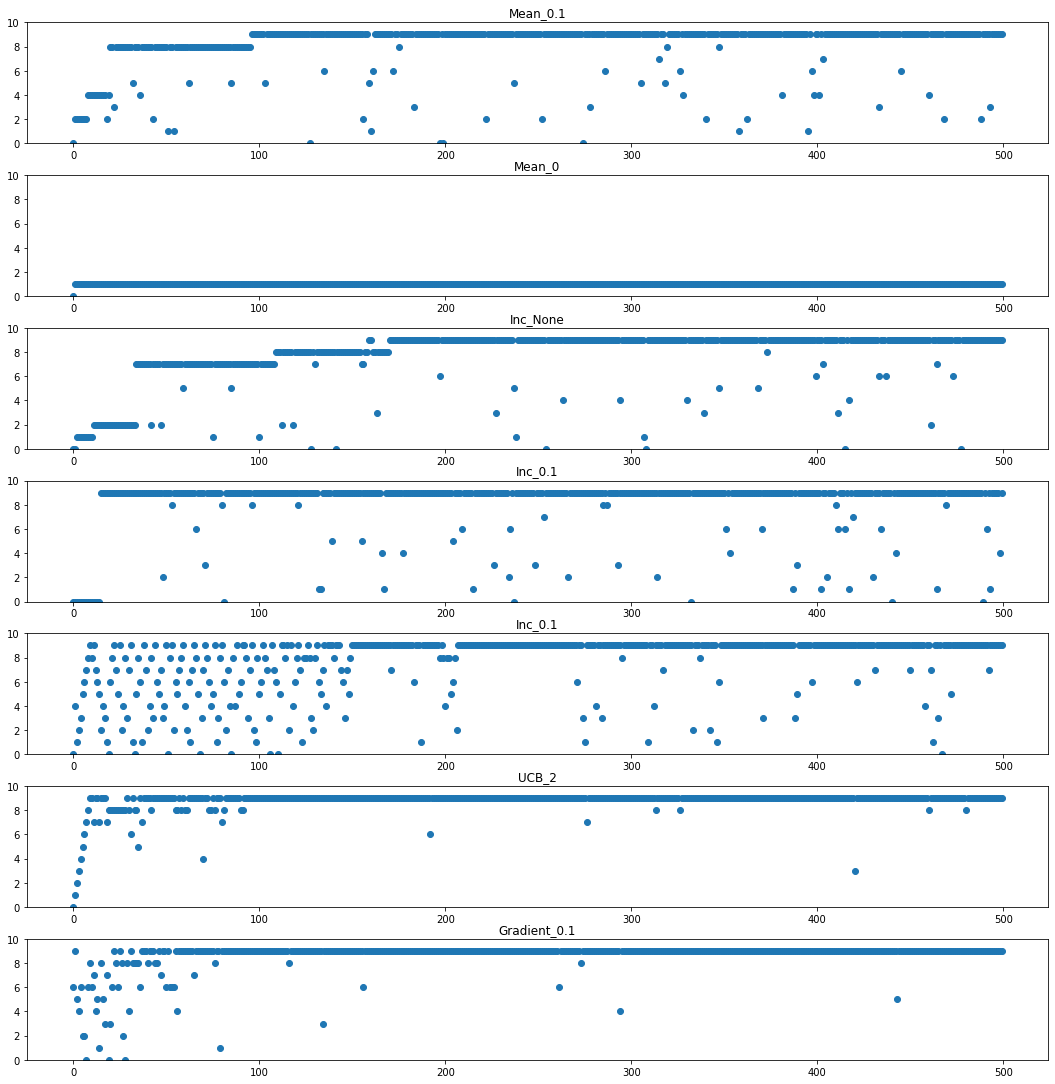

In [18]:
fig, axs = plt.subplots(len(bandits), figsize=(15,15))
fig.tight_layout()

for b in range(len(bandits)):
    axs[b].scatter(range(500), bandits[b].actions)
    axs[b].set_ylim([0, 10])
    axs[b].title.set_text(bandits[b].name)